## Описание набора данных

Приведенный набор данных содержит информацию об игроках Destiny 2 в PVP режиме.

Признак  | Описание
-------------------|--------------------
Light      | Общий уровень игрока
Mobility      | Значение показателя мобильности персонажа - влияет на скорость движения + скорость восстановления классовой способности для класса Hunter
Resilence      | Значение показателя стойкости персонажа - влияет на прочность брони + скорость восстановления классовой способности для класса Titan
Recovery     | Значение показателя восстановления персонажа - влияет скорость восстановления здоровья скорость восстановления классовой способности для класса Warlock
Descipline     | Значение показателя дисциплины персонажа - влияет на скорость восстановления гранаты
Intellect   | Значение показателя интеллекта персонажа - влияет на скорость восстановления суперспособности
Strength     | Значение показателя дисциплины персонажа - влияет на скорость восстановления способности ближнего боя
Class    | Класс персонажа - Titan/Hunter/Warlock
Mode    | PVP-режим игры -  Trials (рейтинговая игра, в которой важен Light); Control, Rumble, Survival (быстрая игра, где показатель Light не имеет значения) 
Total   | Сумма значений показателей mobility-strength

## Загрузка и предварительная обработка данных

Импорт необходимых библиотек

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

Загрузка датасета и удаление ненужных столбцов

In [76]:
df=pd.read_csv('destiny_PVP.csv')
df=df.drop(columns=['tiers_mob','tiers_res','tiers_rec','tiers_dis','tiers_int','tiers_str','tiers'])#убираем эти столбцы, т.к. по сути они содержат частные целочисленных делений соотв. показателей
df

,light,mobility,resilience,recovery,discipline,intellect,strength,class,mode,total
0,1556,31,34,105,22,106,27,Warlock,Trials,325
1,1558,95,63,74,14,68,46,Hunter,Trials,360
2,1559,99,61,71,47,94,24,Hunter,Trials,396
3,1580,55,59,101,24,95,57,Warlock,Control,391
4,1556,88,42,87,34,87,39,Hunter,Trials,377
...,...,...,...,...,...,...,...,...,...,...
18281,1576,55,42,101,86,63,40,Titan,Control,387
18282,1557,50,102,81,37,78,71,Hunter,Trials,419
18283,1549,38,37,103,30,92,46,Warlock,Trials,346
18284,1569,95,28,109,76,60,16,Hunter,Control,384


Немного размышлений про то, что хочется узнать и что можно ожидать:

Было бы интересно узнать как характеристики персонажа потенциально влияют на его возможный класс и режим игры. 

Во-первых каждая из характеристик strength/mobility/recovery дает бонус способности к определенному классу, а значит, вполне возможно у персонажей разных классов будут в приоритете разные харакетристики. Тем не менее, полностью игнорировать другие характеристики тоже не выйдет, т.к. тогда персонаж теряет некоторые свои способности. Т.е. в характеристиках должен быть общий баланс, но возможен упор в некоторые конкретные. Также стоит понимать, что каждый игрок играет по-своему, поэтому характеристики все подбирают строго под свой стиль.

Во-вторых есть показатель Light, который важен только в режиме Trials. Более того, разумно предположить, что идя в рейтинговую игру, игрок будет тщательнее подбирать снаряжение и максимизировать общую сумму Total своих характеристик.

Для наглядности построим гистограммы:

1) Средние значения характеристик у каждого класса

2) Средние значения Light и Total в разных режимах

## Визуализация

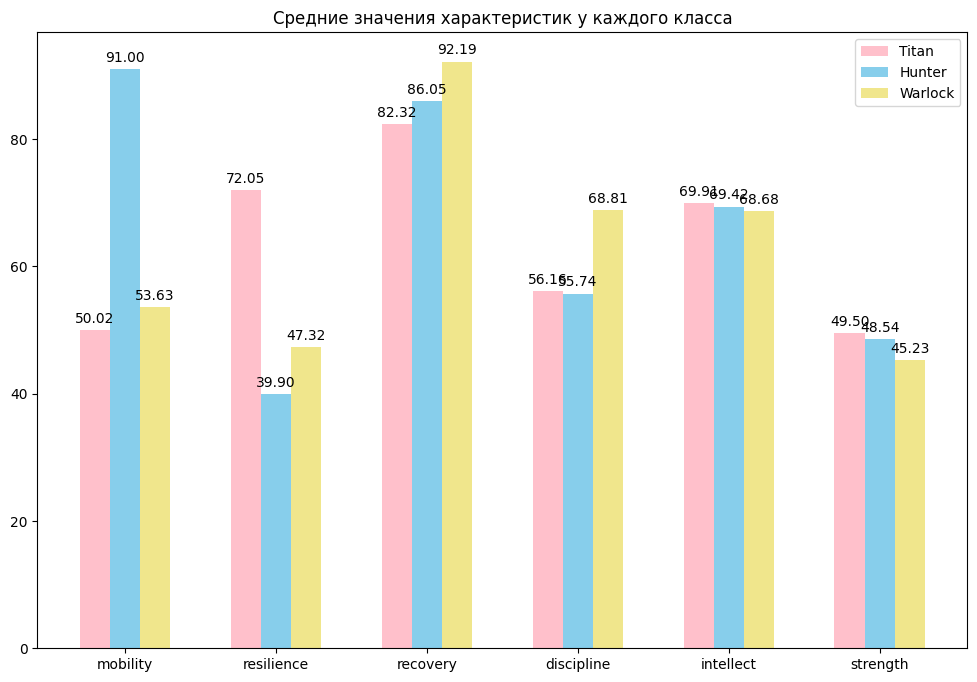

In [77]:
titan_df = df[df['class'] == 'Titan']
mean_titan_mob = titan_df['mobility'].mean()
mean_titan_res= titan_df['resilience'].mean()
mean_titan_rec = titan_df['recovery'].mean()
mean_titan_dis = titan_df['discipline'].mean()
mean_titan_int = titan_df['intellect'].mean()
mean_titan_str = titan_df['strength'].mean()

hunter_df = df[df['class'] == 'Hunter']
mean_hunter_mob = hunter_df['mobility'].mean()
mean_hunter_res= hunter_df['resilience'].mean()
mean_hunter_rec = hunter_df['recovery'].mean()
mean_hunter_dis = hunter_df['discipline'].mean()
mean_hunter_int = hunter_df['intellect'].mean()
mean_hunter_str = hunter_df['strength'].mean()

warlock_df = df[df['class'] == 'Warlock']
mean_warlock_mob = warlock_df['mobility'].mean()
mean_warlock_res= warlock_df['resilience'].mean()
mean_warlock_rec = warlock_df['recovery'].mean()
mean_warlock_dis = warlock_df['discipline'].mean()
mean_warlock_int = warlock_df['intellect'].mean()
mean_warlock_str = warlock_df['strength'].mean()

attributes = ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']

means_titan = [mean_titan_mob, mean_titan_res, mean_titan_rec, mean_titan_dis, mean_titan_int, mean_titan_str]
means_warlock = [mean_warlock_mob, mean_warlock_res, mean_warlock_rec, mean_warlock_dis, mean_warlock_int, mean_warlock_str]
means_hunter = [mean_hunter_mob, mean_hunter_res, mean_hunter_rec, mean_hunter_dis, mean_hunter_int, mean_hunter_str]

x = np.arange(len(attributes))

width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, means_titan, width, label='Titan', color='pink')
rects2 = ax.bar(x, means_hunter, width, label='Hunter', color='skyblue')
rects3 = ax.bar(x + width, means_warlock, width, label='Warlock', color='khaki')


ax.set_title('Средние значения характеристик у каждого класса')
ax.set_xticks(x)
ax.set_xticklabels(attributes)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.show()

Итак, на первом графике видим примерно ожидаемый результат, у каждого класса есть приоритетные характеристики => это не абсолютная случайность, можно пробовать предсказать классы

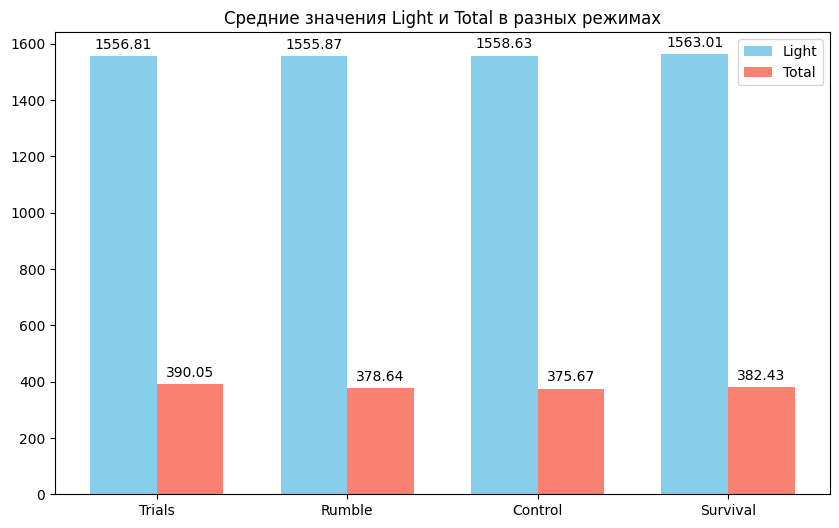

In [78]:
trials_df = df[df['mode'] == 'Trials']
mean_trials_light = trials_df['light'].mean()
mean_trials_total = trials_df['total'].mean()

rumble_df = df[df['mode'] == 'Rumble']
mean_rumble_light = rumble_df['light'].mean()
mean_rumble_total = rumble_df['total'].mean()

control_df = df[df['mode'] == 'Control']
mean_control_light = control_df['light'].mean()
mean_control_total = control_df['total'].mean()

survival_df = df[df['mode'] == 'Survival']
mean_survival_light = survival_df['light'].mean()
mean_survival_total = survival_df['total'].mean()


modes = ['Trials', 'Rumble', 'Control', 'Survival']


means_light = [mean_trials_light, mean_rumble_light, mean_control_light, mean_survival_light]
means_total = [mean_trials_total, mean_rumble_total, mean_control_total, mean_survival_total]


x = list(range(len(modes)))

width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar([i - width/2 for i in x], means_light, width, label='Light', color='skyblue')
rects2 = ax.bar([i + width/2 for i in x], means_total, width, label='Total', color='salmon')



ax.set_title('Средние значения Light и Total в разных режимах')
ax.set_xticks(x)
ax.set_xticklabels(modes)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()


Здесь получаем несколько неожиданный результат, т.к. показатель Light не имеет значения во всех режимах, кроме Trials, однако самое высокое среднее значение мы получили в режиме Survival. Тем не менее, значение Total в Trials наибольшее, что совпадает с гипотезой.

## Постановка задачи

Основной задачей я выбрал предсказание класса по характеристикам персонажа (mobility-strength)

В качестве некого бонуса рассмотрим задачу предсказания режима игры по всем имеющимся характеристикам (не только по Light и Total)

В обоих случаях мы рассматриваем задачу классификации, а значит для модели подойдет KNN

## Реализация модели

In [79]:
df

,light,mobility,resilience,recovery,discipline,intellect,strength,class,mode,total
0,1556,31,34,105,22,106,27,Warlock,Trials,325
1,1558,95,63,74,14,68,46,Hunter,Trials,360
2,1559,99,61,71,47,94,24,Hunter,Trials,396
3,1580,55,59,101,24,95,57,Warlock,Control,391
4,1556,88,42,87,34,87,39,Hunter,Trials,377
...,...,...,...,...,...,...,...,...,...,...
18281,1576,55,42,101,86,63,40,Titan,Control,387
18282,1557,50,102,81,37,78,71,Hunter,Trials,419
18283,1549,38,37,103,30,92,46,Warlock,Trials,346
18284,1569,95,28,109,76,60,16,Hunter,Control,384


In [80]:
df1=df.drop(columns=['mode','total'])
y=df1['class']
X=df1.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=df['class'])
mms=MinMaxScaler()
mms.fit(X_train)
X_train=mms.transform(X_train)
X_test=mms.transform(X_test)
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
f1_scores = f1_score(y_test, y_pred, average=None)

class_labels = knn.classes_

print('F1 score for each class:')
for label, f1 in zip(class_labels, f1_scores):
    print(f"Class: {label}, F1 Score: {f1:.4f}")

print()
print('Overall weighted F1 score:')
print(round(f1_score(y_test, y_pred, average='weighted'),4))

F1 score for each class:
Class: Hunter, F1 Score: 0.8194
Class: Titan, F1 Score: 0.6405
Class: Warlock, F1 Score: 0.5729

Overall weighted F1 score:
0.7009


Итак, получили модель с средним F1 score в районе 0.7. Как мне кажется, неплохой результат. Заметно, что соответствие классу Hunter определяется более успешно, чем у Titan и Warlock - вполне ожидаемо поскольку у Hunter сильно выделяется значение Mobility, что облегчает класссификацию. Касательно самой модели, было установлено, что при различных значениях  количества соседей результаты несколько меняются - чем больше соседей, тем более точный результат получаем. 

Так или иначе можно сделать вывод, что предсказать класс, не самая простая задача и средние значения далеко не самый точный показатель, на который можно опираться. У классов есть приоритетные характеристики, но в общем, можно сказать, что все стремятся к балансу в статах + не списываем со счетов факт индивидуального стиля игры и соответсвующих характеристик.

Теперь перейдем ко второму заданию: определению режима игры по всем известным характеристикам. В рамках игры это интресный вопрос: ты видишь персонажа, его уровень, статы, и предполагаешь, куда он сейчас собирается пойти.
 

In [81]:
df2=df
df2= pd.get_dummies(df2, columns=['class'])
df2

,light,mobility,resilience,recovery,discipline,intellect,strength,mode,total,class_Hunter,class_Titan,class_Warlock
0,1556,31,34,105,22,106,27,Trials,325,False,False,True
1,1558,95,63,74,14,68,46,Trials,360,True,False,False
2,1559,99,61,71,47,94,24,Trials,396,True,False,False
3,1580,55,59,101,24,95,57,Control,391,False,False,True
4,1556,88,42,87,34,87,39,Trials,377,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
18281,1576,55,42,101,86,63,40,Control,387,False,True,False
18282,1557,50,102,81,37,78,71,Trials,419,True,False,False
18283,1549,38,37,103,30,92,46,Trials,346,False,False,True
18284,1569,95,28,109,76,60,16,Control,384,True,False,False


In [82]:
y=df2['mode']
X=df2.drop('mode', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=df['mode'])
mms=MinMaxScaler()
mms.fit(X_train)
X_train=mms.transform(X_train)
X_test=mms.transform(X_test)
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
f1_scores = f1_score(y_test, y_pred, average=None)

class_labels = knn.classes_

print('F1 score for each mode:')
for label, f1 in zip(class_labels, f1_scores):
    print(f"Mode: {label}, F1 Score: {f1:.4f}")

print()
print('Overall weighted F1 score:')
print(round(f1_score(y_test, y_pred, average='weighted'),4))

F1 score for each mode:
Mode: Control, F1 Score: 0.6060
Mode: Rumble, F1 Score: 0.0484
Mode: Survival, F1 Score: 0.0225
Mode: Trials, F1 Score: 0.5933

Overall weighted F1 score:
0.566


Большую точность получаем на Control и Trials, в свою очередь, Rumble и Survival  при увеличении количества соседей вовсе перестают определяться (думаю, это связано с малым количеством этих значений в выборке по сравнению с объемами Control и Trials).

## Итог

Основные выводы и оценки уже были приведены в предыдущем пункте после кода, здесь будут некоторые общие слова. Вообще мне всегда было интересно узнать, а можно ли по снаряжению и билду героя предполагать, что у него за класс, и в какую активность он собирается пойти в таком виде. Как оказалось это совсем не тривиальная задача, каждый игрок подбирает так называемый билд под себя, и этот выбор зависит от множества факторов, которые я много раз уже упоминал.

В целом я считаю проект успешным, скину его своим друзьям, с которыми раньше играл в дестени.